In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# general packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time


#preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
wordsToRemove = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

#Encoding
from tensorflow.keras.preprocessing.text import Tokenizer

#Padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

#plot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!pip install sentencepiece
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 25.2MB/s]


In [2]:
#Modeling
import tensorflow as tf
from keras.layers import Bidirectional,LSTM,Dense, Input, Embedding, concatenate, Dot, AdditiveAttention,Activation
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, median_absolute_error
from keras.callbacks import  EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
import tensorflow_hub as hub
import re

####Loading Data

In [3]:
# dataframe that holds training data
train_df = pd.read_csv("data/train.csv", encoding="latin")
train_df.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
# dataframe that holds attributes info
attributes_df = pd.read_csv("data/attributes.csv")
attributes_df.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [5]:
# dataframe that holds product description info
prod_desc_df = pd.read_csv("data/product_descriptions.csv")
prod_desc_df.set_index("product_uid",inplace=True)
prod_desc_df.head()

,product_description
product_uid,
100001,"Not only do angles make joints stronger, they ..."
100002,BEHR Premium Textured DECKOVER is an innovativ...
100003,Classic architecture meets contemporary design...
100004,The Grape Solar 265-Watt Polycrystalline PV So...
100005,Update your bathroom with the Delta Vero Singl...


In [6]:
print("Total number of products: ", len(train_df["product_uid"].unique()))
train_df.shape

Total number of products:  54667


(74067, 5)

####Preprocessing

In [7]:
class Preprocesser(object):
    def __init__(self, punctuation=True, url=True):
        self.punctuation = punctuation
        self.url = url
    
    def apply(self, text):
        
        text = self._lowercase(text)
        
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
        
    def _remove_punctuation(self, text):
                
        for c in string.punctuation:
            text = re.sub(f"\{c}"," ",text)
        
        return text
    
    def _remove_url(self, text):
        text = re.sub(r'http\S+',"",text)
        return text
    
    def _lowercase(self, text):
        return text.lower()

####Tokenization

In [8]:
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    return [lemmatizer.lemmatize(x) for x in text.split(" ") if x not in wordsToRemove]

In [9]:
preprocesser = Preprocesser()

#preprocessing title
train_df["preprocessed_title"] = train_df["product_title"].astype(str).apply(lambda x: preprocesser.apply(x)).apply(lambda x : tokenize(x))

#preprocessing product description
train_df["product_description"] = train_df["product_uid"].astype(int).apply(lambda x: prod_desc_df.loc[x].product_description)
train_df["preprocessed_description"] = train_df["product_description"].astype(str).apply(lambda x: preprocesser.apply(x)).apply(lambda x : tokenize(x))

In [10]:
train_df.head(1)

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ..."


In [11]:
#getting attributes from attributes df and joining to train df
def getAttributes(product_id):
    #get product_attributes based on product_uid
    att = attributes_df[attributes_df["product_uid"]==product_id][["name","value"]]
    att_1 = att.apply(lambda x : f'{x["name"]} {x["value"]}',axis=1)
    temp = " ".join(att_1.values.tolist())
    return temp


In [12]:
train_df["product_attributes"] =  train_df["product_uid"].astype(int).apply(lambda x: getAttributes(x))
train_df.head()

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description,product_attributes
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,"[behr, premium, textured, deckover, 1, gal, sc...",BEHR Premium Textured DECKOVER is an innovativ...,"[behr, premium, textured, deckover, innovative...","Application Method Brush,Roller,Spray Assemble..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...


In [13]:
#CSV with preprocessed_title, preprocessed_description and product_attributes
train_df.to_csv("prepared_data.csv",index=False)
train_df.head()

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description,product_attributes
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"[simpson, strong, tie, 12, gauge, angle]","Not only do angles make joints stronger, they ...","[angle, make, joint, stronger, also, provide, ...",Bullet01 Versatile connector for various 90° c...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,"[behr, premium, textured, deckover, 1, gal, sc...",BEHR Premium Textured DECKOVER is an innovativ...,"[behr, premium, textured, deckover, innovative...","Application Method Brush,Roller,Spray Assemble..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,"[delta, vero, 1, handle, shower, faucet, trim,...",Update your bathroom with the Delta Vero Singl...,"[update, bathroom, delta, vero, single, handle...",Bath Faucet Type Combo Tub and Shower Built-in...


In [14]:
#df for preprocessed_title, preprocessed_description and product_attributes
train_df["preprocessed_title"] = train_df["preprocessed_title"].apply(lambda x: " ".join(x))
train_df["preprocessed_description"] = train_df["preprocessed_description"].apply(lambda x: " ".join(x))
train_df["preprocessed_attributes"] = train_df["product_attributes"].apply(lambda x: preprocesser.apply(x))

In [15]:
train_df.head()

,id,product_uid,product_title,search_term,relevance,preprocessed_title,product_description,preprocessed_description,product_attributes,preprocessed_attributes
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,simpson strong tie 12 gauge angle,"Not only do angles make joints stronger, they ...",angle make joint stronger also provide consist...,Bullet01 Versatile connector for various 90° c...,bullet01 versatile connector for various 90° c...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,simpson strong tie 12 gauge angle,"Not only do angles make joints stronger, they ...",angle make joint stronger also provide consist...,Bullet01 Versatile connector for various 90° c...,bullet01 versatile connector for various 90° c...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,behr premium textured deckover 1 gal sc 141 tu...,BEHR Premium Textured DECKOVER is an innovativ...,behr premium textured deckover innovative soli...,"Application Method Brush,Roller,Spray Assemble...",application method brush roller spray assemble...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,delta vero 1 handle shower faucet trim kit chr...,Update your bathroom with the Delta Vero Singl...,update bathroom delta vero single handle showe...,Bath Faucet Type Combo Tub and Shower Built-in...,bath faucet type combo tub and shower built in...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,delta vero 1 handle shower faucet trim kit chr...,Update your bathroom with the Delta Vero Singl...,update bathroom delta vero single handle showe...,Bath Faucet Type Combo Tub and Shower Built-in...,bath faucet type combo tub and shower built in...


####Data Split

In [16]:
train, test = train_test_split(train_df,test_size=0.2) 
train, valid = train_test_split(train,test_size=0.2)
print('The size of training set:', train.shape[0])
print('The size of validation set:', valid.shape[0])
print('The size of test set:', test.shape[0])

The size of training set: 47402
The size of validation set: 11851
The size of test set: 14814


####Encoding

In [17]:
#Initialize
encoder_title = Tokenizer(oov_token="<ukn>")
encoder_title.fit_on_texts(train["preprocessed_title"].values)

encoder_descr = Tokenizer(oov_token="<ukn>",num_words=10000)
encoder_descr.fit_on_texts(train["preprocessed_description"].values)

encoder_attribute = Tokenizer(oov_token="<ukn>",num_words=10000)
encoder_attribute.fit_on_texts(train["preprocessed_attributes"].values)

encoder_search_term = Tokenizer(oov_token="<ukn>")
encoder_search_term.fit_on_texts(train["search_term"].values)


In [18]:
#Encoding train set
train_titles = encoder_title.texts_to_sequences(train["preprocessed_title"].values)
train_descr = encoder_descr.texts_to_sequences(train["preprocessed_description"].values)
train_attribute = encoder_attribute.texts_to_sequences(train["preprocessed_attributes"].values)
train_search_term = encoder_search_term.texts_to_sequences(train["search_term"].values)

In [19]:
#Encoding validation set
valid_titles = encoder_title.texts_to_sequences(valid["preprocessed_title"].values)
valid_descr = encoder_descr.texts_to_sequences(valid["preprocessed_description"].values)
valid_attribute = encoder_attribute.texts_to_sequences(valid["preprocessed_attributes"].values)
valid_search_term = encoder_search_term.texts_to_sequences(valid["search_term"].values)

In [20]:
#Encoding test set
test_titles = encoder_title.texts_to_sequences(test["preprocessed_title"].values)
test_descr = encoder_descr.texts_to_sequences(test["preprocessed_description"].values)
test_attribute = encoder_attribute.texts_to_sequences(test["preprocessed_attributes"].values)
test_search_term = encoder_search_term.texts_to_sequences(test["search_term"].values)

####Feature Extraction

In [21]:
titles_length =  max([len(x) for x in train_titles])
descr_length = np.sort([len(x) for x in  train_descr])
desc_length = max(descr_length)
attribute_length = np.sort([len(x) for x in train_attribute])
att_length = max(attribute_length)
search_term_length =  max([len(x) for x in train_search_term])
print("Maximum length of the titles:", titles_length, "\n description:", desc_length, "\n attribute:", att_length,
      "\n search term:", search_term_length)

Maximum length of the titles: 29 
 description: 913 
 attribute: 1058 
 search term: 17


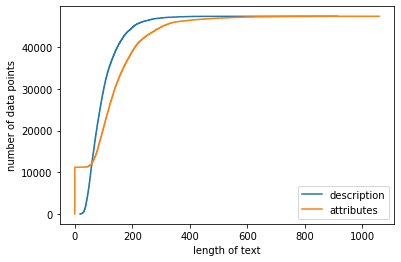

In [22]:
#Plotting length of description and attributes
plt.plot(descr_length,range(len(descr_length)))
plt.plot(attribute_length,range(len(attribute_length)))
plt.xlabel("length of text")
plt.ylabel("number of data points")
plt.legend(["description","attributes"])

####Sequence Padding

In [23]:
#Padding train set
train_titles = pad_sequences(train_titles, maxlen=titles_length)
train_descr = pad_sequences(train_descr, maxlen=200,
                                  truncating="post")

train_attribute = pad_sequences(train_attribute, maxlen=200,
                                truncating="post")

train_search_term = pad_sequences(train_search_term, maxlen=search_term_length)


In [24]:
#Padding valid set
valid_titles = pad_sequences(valid_titles, maxlen=titles_length)
valid_descr = pad_sequences(valid_descr,maxlen=200,
                                  truncating="post")

valid_attribute = pad_sequences(valid_attribute, maxlen=200,
                                truncating="post")

valid_search_term = pad_sequences(valid_search_term, maxlen=search_term_length)


In [25]:
#Padding test set
test_titles = pad_sequences(test_titles,maxlen=titles_length)
test_descr = pad_sequences(test_descr,maxlen=200,
                                 truncating="post")

test_attribute = pad_sequences(test_attribute,maxlen=200,
                               truncating="post")

test_search_term = pad_sequences(test_search_term,maxlen=search_term_length)

In [26]:
#Vocabulary Lengths
title_vocab_len = len(encoder_title.word_index)
descr_vocab_len = len(encoder_descr.word_index)
attr_vocab_len = len(encoder_attribute.word_index)
search_term_vocab_len = len(encoder_search_term.word_index)

In [27]:
print("Vocab Lengths title:", title_vocab_len, "\n description:", descr_vocab_len, 
      "\n attribute:", attr_vocab_len, "\n search term: ", search_term_vocab_len)

Vocab Lengths title: 15170 
 description: 131848 
 attribute: 29104 
 search term:  7638


####Bi-LSTM Model

In [28]:
from keras import  backend
backend.clear_session()

Bidirectional LSTM


In [29]:
lstm_units = 100
epochs = 20

In [30]:
#bi LSTM
#Product title - layers
#shape of title is the length
input_title = Input(shape=(titles_length))
embedding_layer = Embedding(input_dim=(title_vocab_len+1), output_dim=50,input_length=titles_length)
embedding_vectors = embedding_layer(input_title)
lstm = Bidirectional(LSTM(lstm_units,return_sequences=True))(embedding_vectors)
output_title = Bidirectional(LSTM(lstm_units))(lstm)

In [31]:
#Product description - layers
#taking input shape of description 200
input_description = Input(shape=(200))
embedding_layer = Embedding(input_dim=(descr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_description)
lstm = Bidirectional(LSTM(lstm_units,return_sequences=True))(embedding_vectors)
output_description = Bidirectional(LSTM(lstm_units))(lstm)

In [32]:
#Product attribute - layers
#taking input shape of attribute 200
input_attribute = Input(shape=(200))
embedding_layer = Embedding(input_dim=(attr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_attribute)
lstm = Bidirectional(LSTM(lstm_units,return_sequences=True))(embedding_vectors)
output_attribute = Bidirectional(LSTM(lstm_units))(lstm)

In [33]:
#Product title - layers
#shape of title is the length
input_search_term = Input(shape=(search_term_length))
#embedding_layer = Embedding(input_dim=(search_term_vocab_len+1),output_dim=100,input_length=search_term_length)
embedding_layer = Embedding(input_dim=(search_term_vocab_len+1),output_dim=100,input_length=search_term_length)
embedding_vectors = embedding_layer(input_search_term)
output_search_term = Bidirectional(LSTM(lstm_units))(embedding_vectors)

In [34]:
#Calculating cosine similarity
#Merging title, description and attribute with search term one by one
#normalise-->True
#title cosine sim
cosine_sim_title = Dot(axes=-1,normalize=True)([output_title,output_search_term])
cosine_sim_attr = Dot(axes=-1,normalize=True)([output_attribute,output_search_term])
cosine_sim_descr = Dot(axes=-1,normalize=True)([output_description,output_search_term])

In [35]:
#concatinating inputs of title, description and attribute 
#to feed into dense layer
concat_input = concatenate([cosine_sim_title,cosine_sim_descr,cosine_sim_attr])
inputs = Dense(10,activation="relu")(concat_input)

In [36]:
#output layer
output_layer = Dense(1,activation="linear")(inputs)

In [37]:
#Model class
model = Model(inputs=[input_title,input_description,input_attribute,input_search_term], outputs=output_layer)

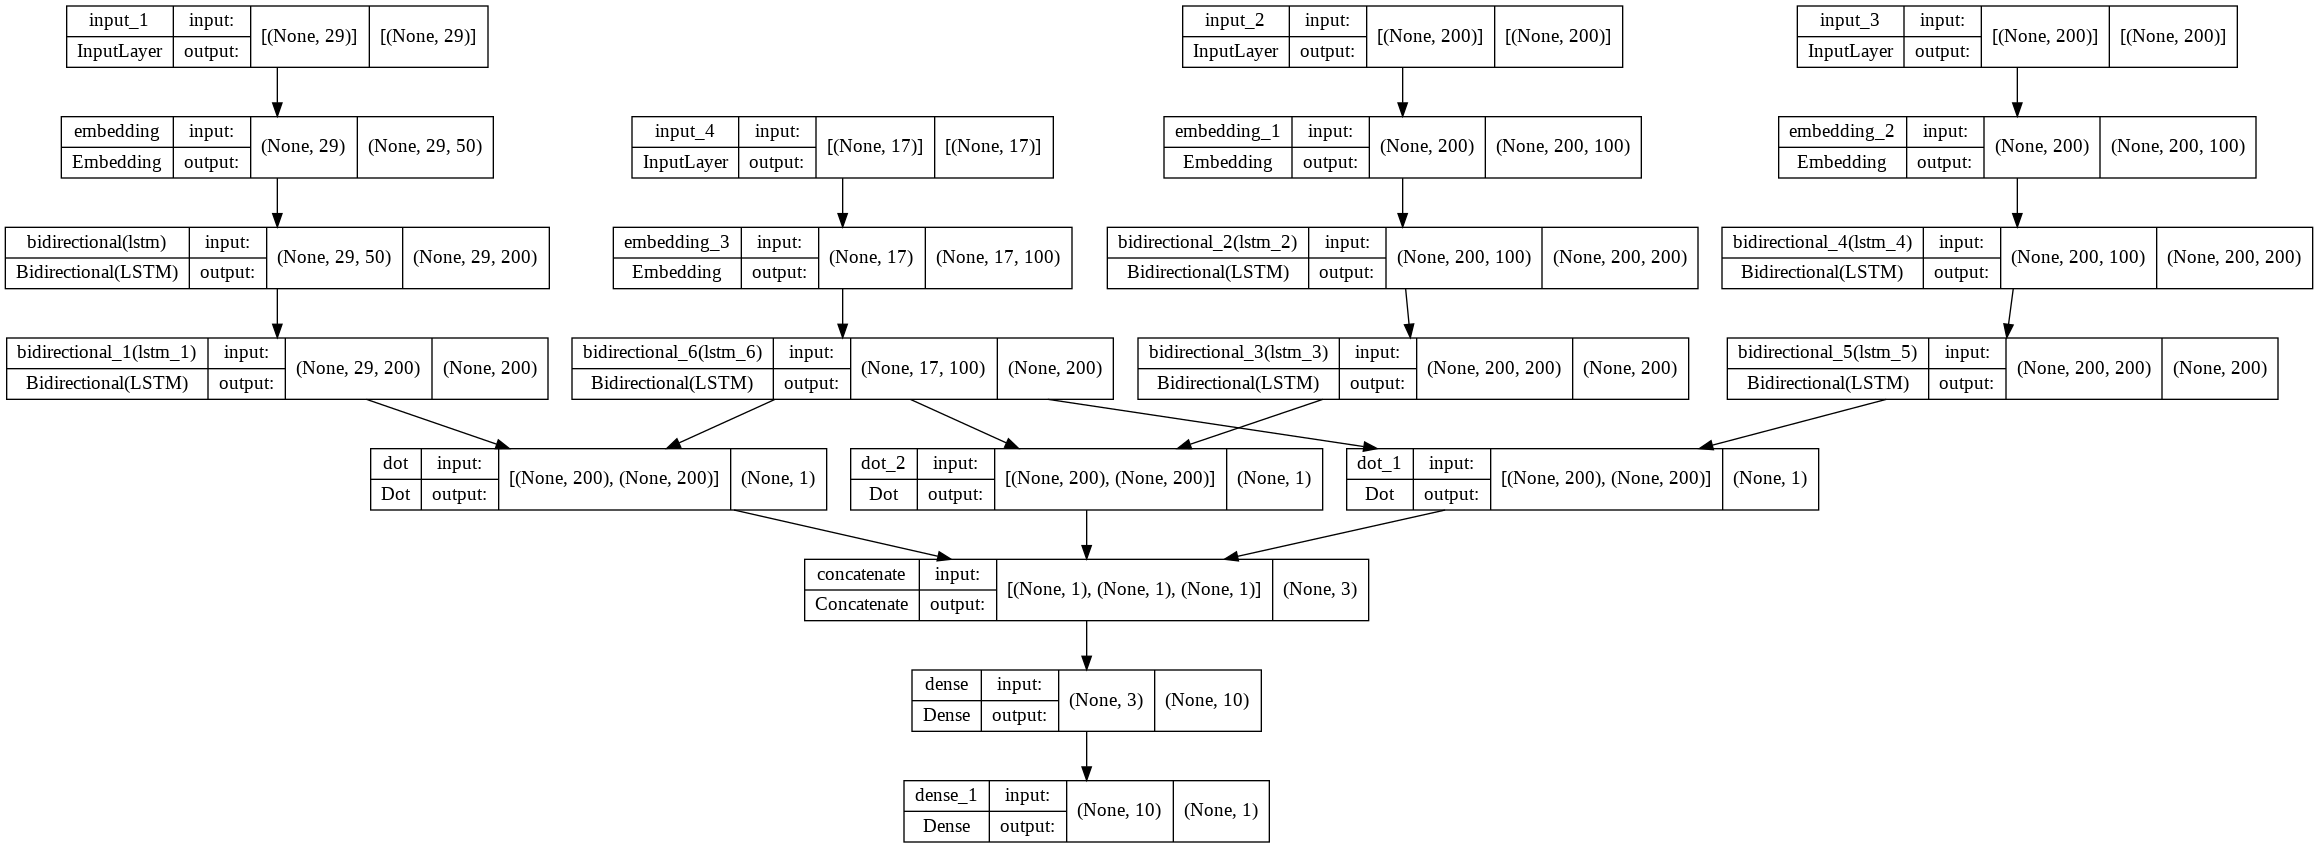

In [38]:
from keras.utils.vis_utils import plot_model

                 

In [39]:
#compile bi lstm model
model.compile(
    optimizer=Adam(learning_rate=0.001),loss='mse',
    metrics=[RootMeanSquaredError()])

In [40]:
#predict relevance
train_pred = train["relevance"].values.reshape(-1,1)
valid_pred = valid["relevance"].values.reshape(-1,1)
test_pred = test["relevance"].values.reshape(-1,1)

####model fit

In [ ]:
history = model.fit(x=[train_titles,train_descr,train_attribute,train_search_term],
                    y=train_pred,epochs=15,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,validation_data=(
    [valid_titles,valid_descr,valid_attribute,valid_search_term],
    valid_pred
))

Epoch 1/15
47/47 [==============================] - 35s 744ms/step - loss: 1.4241 - root_mean_squared_error: 1.1933 - val_loss: 0.8177 - val_root_mean_squared_error: 0.9043
Epoch 2/15
47/47 [==============================] - 31s 664ms/step - loss: 0.5648 - root_mean_squared_error: 0.7515 - val_loss: 0.3855 - val_root_mean_squared_error: 0.6209
Epoch 3/15
47/47 [==============================] - 32s 685ms/step - loss: 0.3240 - root_mean_squared_error: 0.5692 - val_loss: 0.2948 - val_root_mean_squared_error: 0.5430
Epoch 4/15
47/47 [==============================] - 32s 691ms/step - loss: 0.2874 - root_mean_squared_error: 0.5361 - val_loss: 0.2881 - val_root_mean_squared_error: 0.5367
Epoch 5/15
47/47 [==============================] - 32s 682ms/step - loss: 0.2847 - root_mean_squared_error: 0.5335 - val_loss: 0.2840 - val_root_mean_squared_error: 0.5329
Epoch 6/15
47/47 [==============================] - 32s 687ms/step - loss: 0.2674 - root_mean_squared_error: 0.5171 - val_loss: 0.2597 

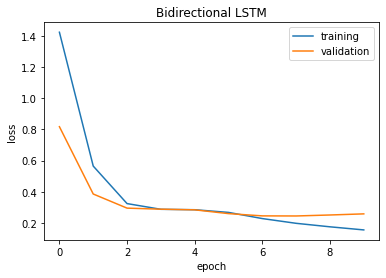

In [ ]:
#plot training and val loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bidirectional LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [ ]:
#Calculating Error
y_pred = model.predict([test_titles,test_descr,test_attribute,test_search_term])

rmse = mean_squared_error(y_pred,test_pred,squared=False)
mse = mean_squared_error(y_pred,test_pred)
mae = median_absolute_error(y_pred,test_pred)

In [ ]:
print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.48885810258269385
MSE on test data  : 0.23898224446075164
MAE on test data  : 0.38336265087127686


Text(0, 0.5, 'Actual Relevance')

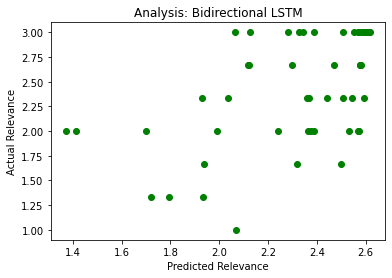

In [ ]:
plt.scatter(y_pred[:50],test_pred[:50],c="g")
plt.title("Analysis: Bidirectional LSTM")
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")

In [ ]:
#Time taken by BiLSTM

t = time.time()
title = encoder_title.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = encoder_descr.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = encoder_attribute.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = encoder_search_term.texts_to_sequences(test["search_term"].values[0:1])

title = pad_sequences(title,maxlen=titles_length)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=search_term_length)

pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by BI LSTM model to predict the relevance: ",time_taken)

Time taken by BI LSTM model to predict the relevance:  0.1773061752319336


####Attention Model

In [ ]:
backend.clear_session()

In [ ]:
#Attention
#Product title - layers
#shape of title is the length
input_title = Input(shape=(titles_length))
embedding_layer = Embedding(input_dim=(title_vocab_len+1),output_dim=50,input_length=titles_length)
embedding_vectors = embedding_layer(input_title)
output_title, forward_h, forward_c, backward_h, backward_c = Bidirectional(
    LSTM(lstm_units,return_state=True,dropout=0.25))(embedding_vectors)
title_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
title_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [ ]:
#Product description - layers
#taking input shape of description 200
input_description = Input(shape=(200))
embedding_layer = Embedding(input_dim=(descr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_description)
output_description, forward_h, forward_c, backward_h, backward_c = Bidirectional(
    LSTM(100,return_state=True,dropout=0.25))(embedding_vectors)
description_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
description_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [ ]:
#Product attribute - layers
#taking input shape of attribute 200
input_attribute = Input(shape=(200))
embedding_layer = Embedding(input_dim=(attr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_attribute)
output_attribute, forward_h, forward_c, backward_h, backward_c = Bidirectional(
    LSTM(100,return_state=True,dropout=0.25))(embedding_vectors)
attr_state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
attr_state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

In [ ]:
#Product search term - layers
#shape of search term is the length
input_search_term = Input(shape=(search_term_length))
embedding_layer = Embedding(input_dim=(search_term_vocab_len+1),output_dim=100,input_length=search_term_length)
embedding_vectors = embedding_layer(input_search_term)
output_search_term = Bidirectional(LSTM(100))(embedding_vectors)


In [ ]:
#Using reference from BahdanauAttention
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.w1 = Dense(units)
        self.w2 = Dense(units)
        self.V = Dense(1)
    def call(self, input, values):
      # hidden shape --> (batch_size, hidden size)
      # hidden_with_time_axis shape --> (batch_size, 1, hidden size)
        hidden_with_time_axis = tf.expand_dims(values, 1)
      # score shape --> (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.w1(input) + self.w2(hidden_with_time_axis))
      # attention_weights shape --> (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
      # context_vector shape after sum --> (batch_size, hidden_size)
        context_vector = attention_weights * input
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
#Calculating context vectors
#Merging title, description and attribute hiiden state
#with search term one by one to get context vectors and 
#attention weights
#title context vector
context_vector_title, attention_weights = Attention(100)(output_search_term, title_state_h)
#description_state context vector
context_vector_descr, attention_weights = Attention(100)(output_search_term, description_state_h)
#attribute context vector
context_vector_attr, attention_weights = Attention(100)(output_search_term, attr_state_h)

In [ ]:
#Concatenate all context vectors
con_layer = concatenate([context_vector_title,context_vector_descr,context_vector_attr])
dense = Dense(10,activation="relu")(con_layer)
output_layer = Dense(1,activation="linear")(dense)

In [ ]:
#feeding the input and output layers to the model
model = Model(inputs=[input_title,input_description,input_attribute,input_search_term], outputs=output_layer)

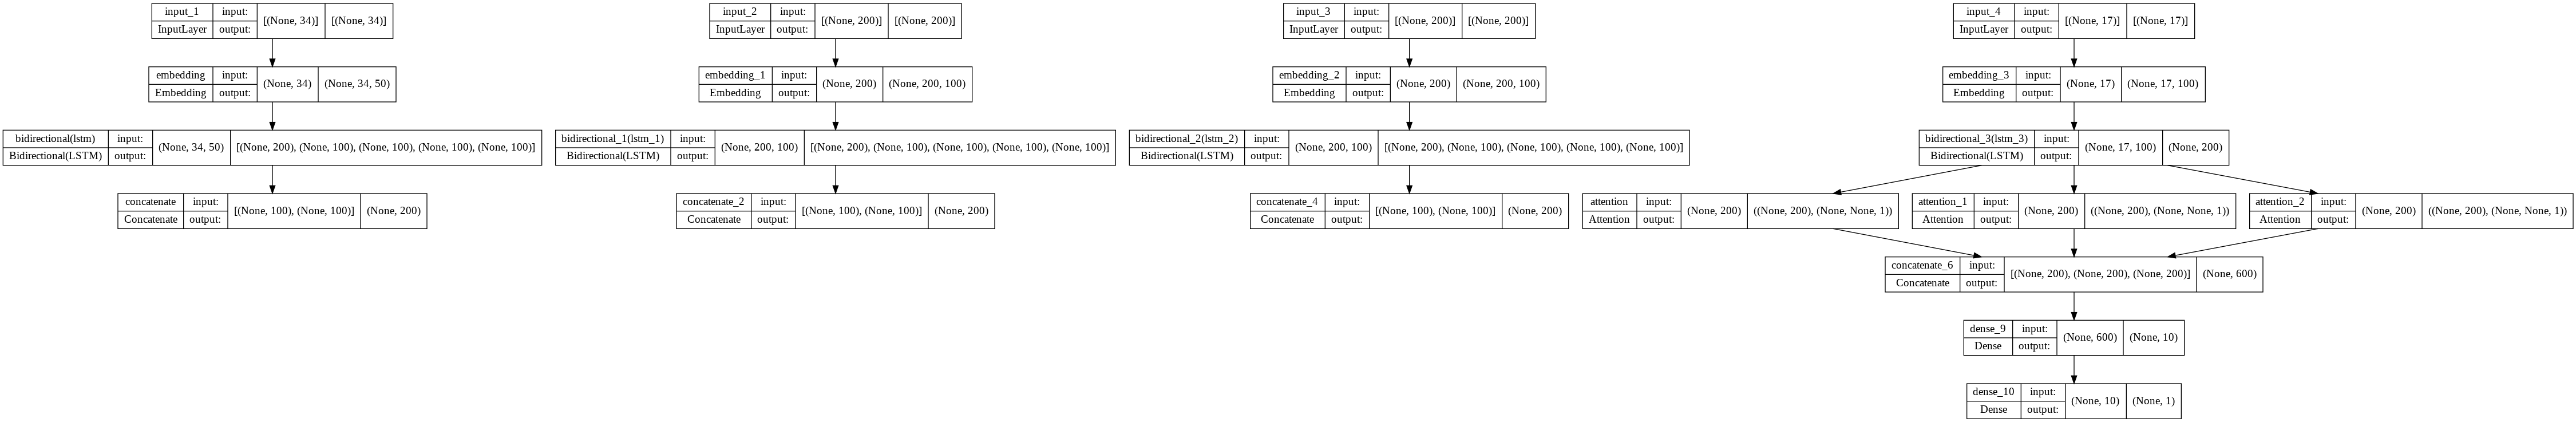

In [ ]:
plot_model(model, to_file='Attention plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#compile attention model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse', metrics=[RootMeanSquaredError()])


In [ ]:
attention = model.fit(x=[train_titles,train_descr,train_attribute,train_search_term],
                      y=train_pred,epochs=30,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)] ,
                      validation_data=([valid_titles,valid_descr,valid_attribute,valid_search_term],
                                       valid_pred
                      ))

Epoch 1/30
47/47 [==============================] - 79s 613ms/step - loss: 5.0634 - root_mean_squared_error: 2.2502 - val_loss: 3.3858 - val_root_mean_squared_error: 1.8401
Epoch 2/30
47/47 [==============================] - 26s 547ms/step - loss: 1.1340 - root_mean_squared_error: 1.0649 - val_loss: 0.3040 - val_root_mean_squared_error: 0.5513
Epoch 3/30
47/47 [==============================] - 25s 543ms/step - loss: 0.2913 - root_mean_squared_error: 0.5397 - val_loss: 0.2884 - val_root_mean_squared_error: 0.5370
Epoch 4/30
47/47 [==============================] - 26s 544ms/step - loss: 0.2858 - root_mean_squared_error: 0.5346 - val_loss: 0.2883 - val_root_mean_squared_error: 0.5370
Epoch 5/30
47/47 [==============================] - 26s 545ms/step - loss: 0.2857 - root_mean_squared_error: 0.5345 - val_loss: 0.2883 - val_root_mean_squared_error: 0.5369
Epoch 6/30
47/47 [==============================] - 26s 545ms/step - loss: 0.2858 - root_mean_squared_error: 0.5346 - val_loss: 0.2883 

In [ ]:
y_pred = model.predict([test_titles,test_descr,test_attribute,test_search_term])

rmse = mean_squared_error(y_pred,test_pred,squared=False)
mse = mean_squared_error(y_pred,test_pred)
mae = median_absolute_error(y_pred,test_pred)

In [ ]:
print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.5295950992943332
MSE on test data  : 0.2804709691965747
MAE on test data  : 0.3848150587081909


In [ ]:
#Time taken by ATTENTION

t = time.time()
title = encoder_title.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = encoder_descr.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = encoder_attribute.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = encoder_search_term.texts_to_sequences(test["search_term"].values[0:1])

In [ ]:
title = pad_sequences(title,maxlen=titles_length)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=search_term_length)

In [ ]:
pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by Attention model to predict the relevance: ",time_taken)

Time taken by Attention model to predict the relevance:  4.182840347290039


####Conv1D Model

In [ ]:
backend.clear_session()
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

In [ ]:
#Conv1D
#Product title - layers
#shape of title is the length
input_title = Input(shape=(titles_length))
embedding_layer = Embedding(input_dim=(title_vocab_len+1),output_dim=50,input_length=titles_length)
embedding_vectors = embedding_layer(input_title)
dropout = Dropout(0.25)(embedding_vectors)
conv = Conv1D(100, 5, activation='relu',padding="same")(dropout)
output_title = GlobalMaxPooling1D()(conv)

In [ ]:
#Product description - layers
#taking input shape of description 200
input_description = Input(shape=(200))
embedding_layer = Embedding(input_dim=(descr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_description)
dropout = Dropout(0.25)(embedding_vectors)
conv = Conv1D(100, 5, activation='relu',padding="same")(dropout)
output_description = GlobalMaxPooling1D()(conv)

In [ ]:
#Product attribute - layers
#taking input shape of attribute 200
input_attribute = Input(shape=(200))
embedding_layer = Embedding(input_dim=(attr_vocab_len+1),output_dim=100,input_length=200)
embedding_vectors = embedding_layer(input_attribute)
dropout = Dropout(0.25)(embedding_vectors)
conv = Conv1D(100, 5, activation='relu',padding="same")(dropout)
output_attribute = GlobalMaxPooling1D()(conv)

In [ ]:
#Product search term - layers
#shape of search term is the length
input_search_term = Input(shape=(search_term_length))
embedding_layer = Embedding(input_dim=(search_term_vocab_len+1),output_dim=100,input_length=search_term_length)
dropout = Dropout(0.25)(embedding_vectors)
conv = Conv1D(100, 5, activation='relu',padding="same")(dropout)
output_search_term = GlobalMaxPooling1D()(conv)

In [ ]:
#Calculating cosine similarity
#Merging title, description and attribute with search term one by one
#normalise-->True
#title cosine sim
cosine_sim_title = Dot(axes=-1,normalize=True)([output_title,output_search_term])
cosine_sim_descr = Dot(axes=-1,normalize=True)([output_description,output_search_term])
cosine_sim_attr = Dot(axes=-1,normalize=True)([output_attribute,output_search_term])

In [ ]:
#concatinating iniputs for dense layer
#title, description and attribute 
concat_inputs = concatenate([cosine_sim_title,cosine_sim_descr,cosine_sim_attr])
inputs_1 = Dense(64,activation="relu")(concat_inputs)
inputs = Dense(10,activation="relu")(concat_inputs)
output_layer = Dense(1,activation="linear")(inputs)

In [ ]:
#feeding the input and output layers to the model
model = Model(inputs=[input_title,input_description,input_attribute,input_search_term], outputs=output_layer)

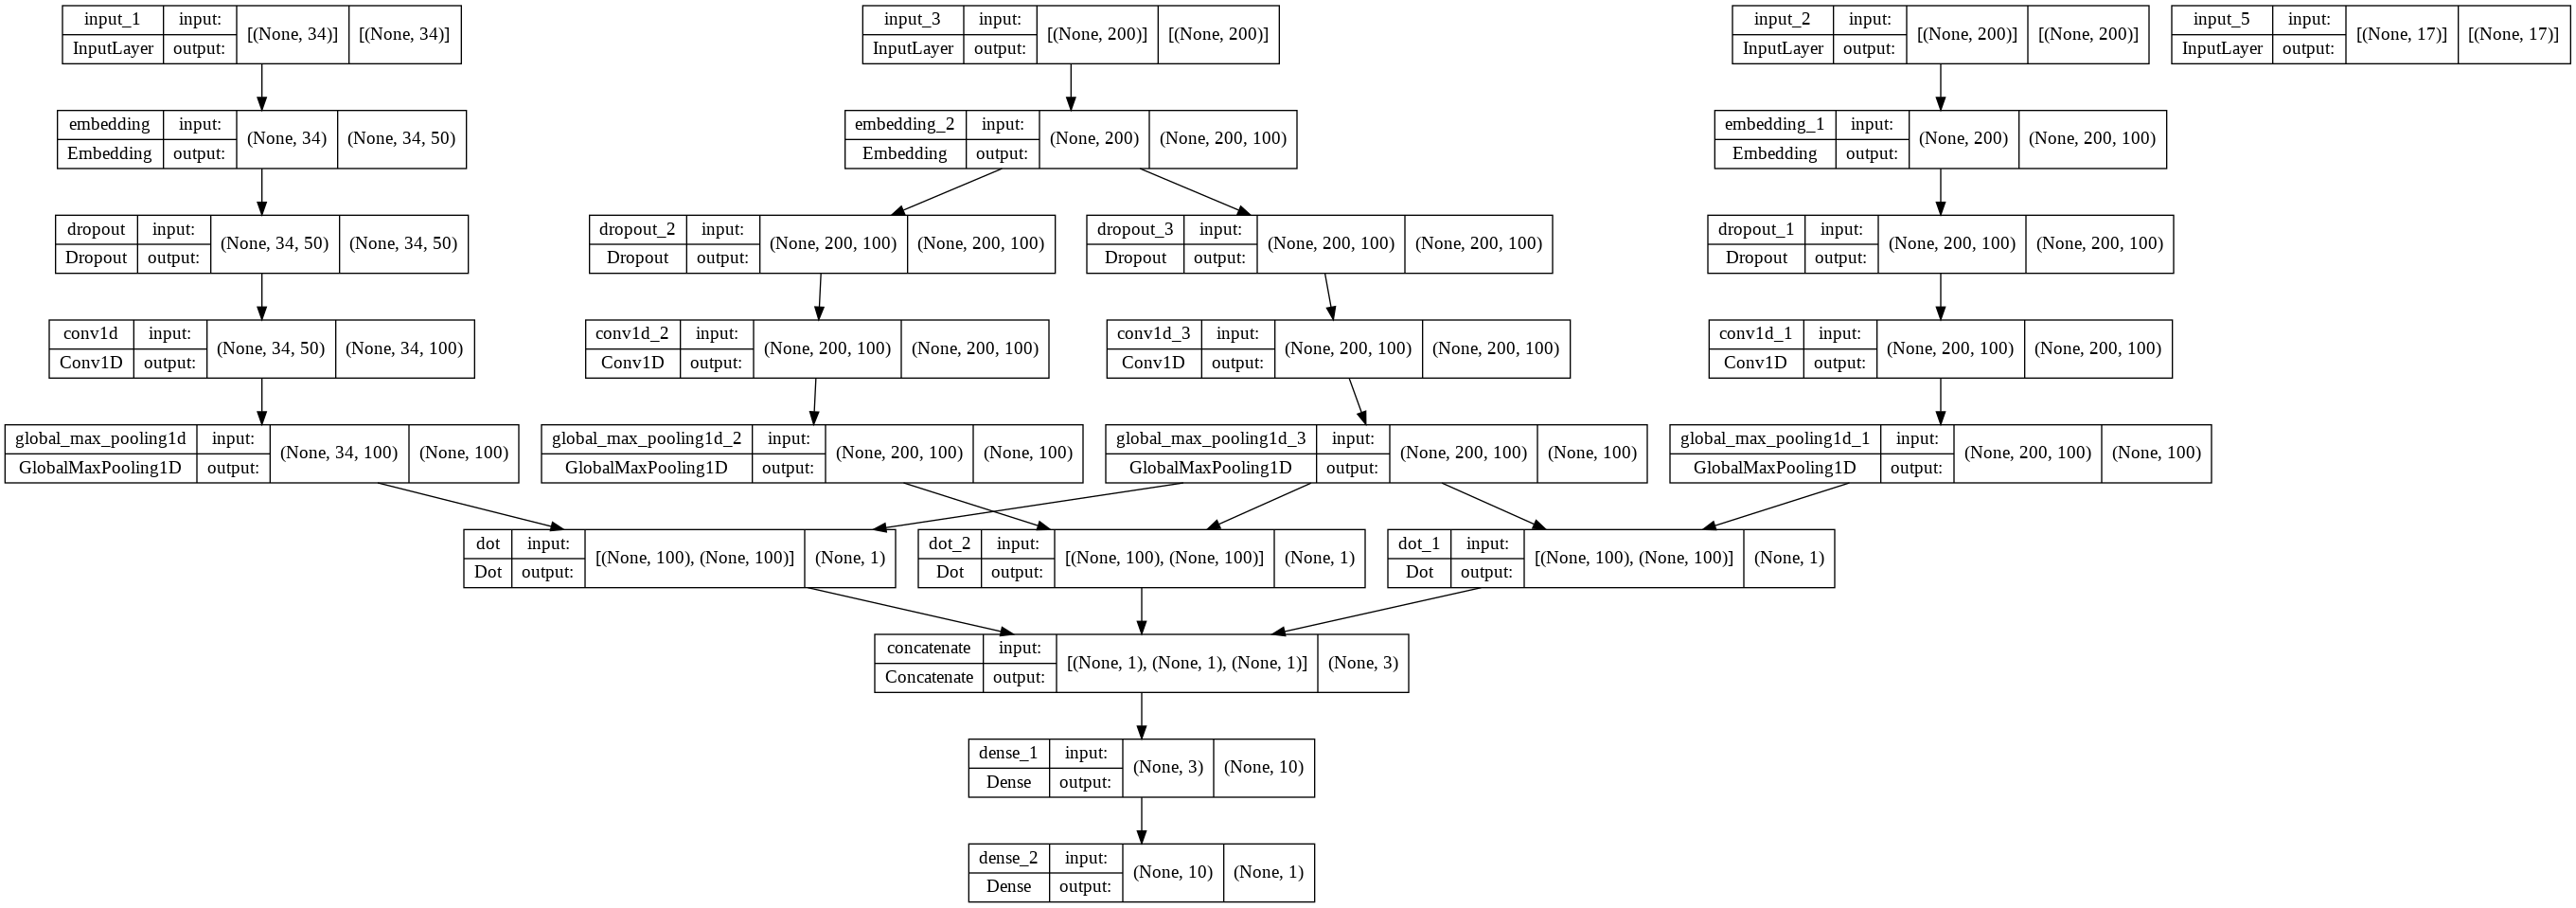

In [ ]:
plot_model(model, to_file='Conv1D plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
    loss='mse', metrics=[RootMeanSquaredError()])

In [ ]:
conv1d = model.fit(x=[train_titles,train_descr,train_attribute,train_search_term],
                   y=train_pred,epochs=35,batch_size=1024,callbacks=[EarlyStopping(patience=2,restore_best_weights=True)],
                   validation_data=([valid_titles,valid_descr,valid_attribute,valid_search_term],valid_pred
                  ))

Epoch 1/35
47/47 [==============================] - 19s 152ms/step - loss: 1.6173 - root_mean_squared_error: 1.2717 - val_loss: 1.5459 - val_root_mean_squared_error: 1.2433
Epoch 2/35
47/47 [==============================] - 6s 136ms/step - loss: 1.4029 - root_mean_squared_error: 1.1844 - val_loss: 1.3491 - val_root_mean_squared_error: 1.1615
Epoch 3/35
47/47 [==============================] - 6s 137ms/step - loss: 1.2459 - root_mean_squared_error: 1.1162 - val_loss: 1.1917 - val_root_mean_squared_error: 1.0916
Epoch 4/35
47/47 [==============================] - 6s 138ms/step - loss: 1.1116 - root_mean_squared_error: 1.0543 - val_loss: 1.0582 - val_root_mean_squared_error: 1.0287
Epoch 5/35
47/47 [==============================] - 7s 143ms/step - loss: 0.9933 - root_mean_squared_error: 0.9967 - val_loss: 0.9424 - val_root_mean_squared_error: 0.9708
Epoch 6/35
47/47 [==============================] - 7s 139ms/step - loss: 0.8882 - root_mean_squared_error: 0.9425 - val_loss: 0.8411 - val

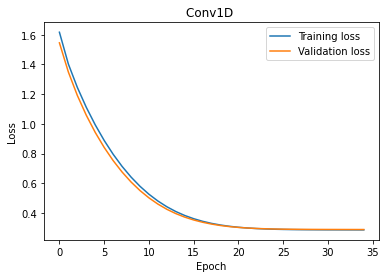

In [ ]:
plt.plot(range(len(conv1d.history["loss"])), conv1d.history["loss"], conv1d.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('Conv1D ')
plt.show()

In [ ]:
#Calculating Error
y_pred = model.predict([test_titles,test_descr,test_attribute,test_search_term])
rmse = mean_squared_error(y_pred,test_pred,squared=False)
mse = mean_squared_error(y_pred,test_pred)
mae = median_absolute_error(y_pred,test_pred)

In [ ]:
print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.5297197378000695
MSE on test data  : 0.28060300061497445
MAE on test data  : 0.3779376745223999


Text(0.5, 1.0, 'Analysis on Conv1D')

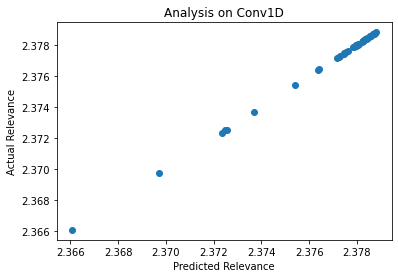

In [ ]:
plt.scatter(y_pred[:50],y_pred[:50])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")
plt.title("Analysis on Conv1D")
##The below graph is wrong

In [ ]:
#Time taken by ATTENTION

t = time.time()
title = encoder_title.texts_to_sequences(test["preprocessed_title"].values[0:1])
descr = encoder_descr.texts_to_sequences(test["preprocessed_description"].values[0:1])
attr = encoder_attribute.texts_to_sequences(test["preprocessed_attributes"].values[0:1])
search_term_ = encoder_search_term.texts_to_sequences(test["search_term"].values[0:1])

In [ ]:
title = pad_sequences(title,maxlen=titles_length)
descr = pad_sequences(descr,maxlen=200,truncating="post")
attr = pad_sequences(attr,maxlen=200,truncating="post")
search_term_ = pad_sequences(search_term_,maxlen=search_term_length)


In [ ]:
pred = model.predict([title,descr,attr,search_term_])
time_taken = time.time()-t
print("Time taken by conv 1D model to predict the relevance: ",time_taken)

Time taken by conv 1D model to predict the relevance:  16.2862868309021


####BERT

In [41]:
from keras import backend
backend.clear_session()

In [42]:
#Building model using tf.keras and hub. from sentences to embeddings.
#Inputs: input token ids (tokenizer converts tokens using vocab file)
#input masks (1 for useful tokens, 0 for padding)
#segment ids (for 2 text training: 0 for the first one, 1 for the second one)
#Taking maximum sequence length for title 20
max_seq_length = 30

#Initializing inputs here
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32)
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])


In [43]:
#
model_titles = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [44]:
#Generating segments and masks based on the original BERT
#BERT paper: https://arxiv.org/pdf/1810.04805.pdf

In [45]:
#Import tokenizer using the original vocab file
import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer=tokenization.FullTokenizer(vocab_file,do_lower_case )


In [46]:
def mask_and_segment(array,max_seq_length):
  X_mask=[]
  X_segment=[]
  X_tokens=[]
  for t in array:
      #Token ids from Tokenizer vocab
      token = tokenizer.tokenize(t)
      #Get segments
      if len(token)==max_seq_length-2:
              tokens = ['[CLS]',*token,'[SEP]']
      elif len(token)>max_seq_length-2:
              tokens = ['[CLS]',*token[:max_seq_length-2],'[SEP]']
      #else Mask for padding
      else:
              pad_len = (max_seq_length-2)-len(token)
              pads = ['[PAD]']*pad_len
              tokens = ['[CLS]',*token,*pads,'[SEP]']
              
      mask = [1 if i!='[PAD]' else 0 for i in tokens]
      segment = [0]*max_seq_length
      tokens = tokenizer.convert_tokens_to_ids(tokens)  
      X_mask.append(mask)  
      X_segment.append(segment)  
      X_tokens.append(tokens) 

  return (np.array(X_tokens),np.array(X_mask),np.array(X_segment))  

In [47]:
#Applying masking and segmentation on train, valid and test
train_titles_tokens,train_titles_mask,train_titles_segment = mask_and_segment(train['preprocessed_title'],30)

valid_titles_tokens,cv_titles_mask,cv_titles_segment = mask_and_segment(valid['preprocessed_title'],30)

test_titles_tokens,test_titles_mask,test_titles_segment = mask_and_segment(test['preprocessed_title'],30)

In [48]:
#pooled output for titles
train_titles_pooled_output = model_titles.predict((train_titles_tokens,train_titles_mask,train_titles_segment))

valid_titles_pooled_output = model_titles.predict((valid_titles_tokens,cv_titles_mask,cv_titles_segment))

test_titles_pooled_output = model_titles.predict((test_titles_tokens,test_titles_mask,test_titles_segment))

In [49]:
#Taking maximum sequence length for description 100
max_seq_length = 150

#Initializing inputs here
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32)
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Applying masking and segmentation on train, valid and test
train_descr_tokens,train_descr_mask,train_descr_segment = mask_and_segment(train['preprocessed_attributes'],150)

valid_descr_tokens,valid_descr_mask,valid_descr_segment = mask_and_segment(valid['preprocessed_attributes'],150)

test_descr_tokens,test_descr_mask,test_descr_segment = mask_and_segment(test['preprocessed_attributes'],150)

model_attr_descr = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

#pooled output for description
train_descr_pooled_output = model_attr_descr.predict((train_descr_tokens,train_descr_mask,train_descr_segment))

valid_descr_pooled_output = model_attr_descr.predict((valid_descr_tokens,valid_descr_mask,valid_descr_segment))

test_descr_pooled_output = model_attr_descr.predict((test_descr_tokens,test_descr_mask,test_descr_segment))

In [50]:
#Applying masking and segmentation on train, valid and test -- attributes
train_attributes_tokens,train_attributes_mask,train_attributes_segment = mask_and_segment(train['preprocessed_attributes'],150)

valid_attributes_tokens,valid_attributes_mask,valid_attributes_segment = mask_and_segment(valid['preprocessed_attributes'],150)

test_attributes_tokens,test_attributes_mask,test_attributes_segment = mask_and_segment(test['preprocessed_attributes'],150)

#pooled output for attributes
train_attributes_pooled_output = model_attr_descr.predict((train_attributes_tokens,train_attributes_mask,train_attributes_segment))

valid_attributes_pooled_output = model_attr_descr.predict((valid_attributes_tokens,valid_attributes_mask,valid_attributes_segment))

test_attributes_pooled_output = model_attr_descr.predict((test_attributes_tokens,test_attributes_mask,test_attributes_segment))

In [51]:
#Taking maximum sequence length for search term 12
max_seq_length = 15

#Initializing inputs here
input_word_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
input_mask = Input(shape=(max_seq_length,), dtype=tf.int32)
segment_ids = Input(shape=(max_seq_length,), dtype=tf.int32)
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Applying masking and segmentation on train, valid and test
train_search_term_tokens,train_search_term_mask,train_search_term_segment = mask_and_segment(train['search_term'],15)

valid_search_term_tokens,valid_search_term_mask,valid_search_term_segment = mask_and_segment(valid['search_term'],15)

test_search_term_tokens,test_search_term_mask,test_search_term_segment = mask_and_segment(test['search_term'],15)

model_searchterm = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

#pooled output for description
train_search_term_pooled_output=model_searchterm.predict((train_search_term_tokens,train_search_term_mask,
                                                      train_search_term_segment))

valid_search_term_pooled_output=model_searchterm.predict((valid_search_term_tokens,valid_search_term_mask,
                                                   valid_search_term_segment))

test_search_term_pooled_output=model_searchterm.predict((test_search_term_tokens,test_search_term_mask,
                                                     test_search_term_segment))

In [52]:
backend.clear_session()

input_title = Input((768,))
dense_title = Dense(256,activation='linear')(input_title)

input_description = Input((768,))
dropout = Dropout(.25)(input_description)
dense_description = Dense(256,activation='linear')(dropout)

input_attr = Input((768,))
dropout = Dropout(.25)(input_attr)
dense_attr = Dense(256,activation='linear')(dropout)

input_search_term = Input((768,))
dropout = Dropout(.25)(input_search_term)
dense_search_term = Dense(256,activation='linear')(dropout)

In [53]:
#concatenating the inputs to feed into dense layer
concat_layer = concatenate([dense_title,dense_description,dense_attr,dense_search_term])
dense_layer = Dense(128,activation="linear")(concat_layer)
dense_layer = Dense(64,activation="relu")(dense_layer)

#output layer
output_layer = Dense(1,activation='linear')(dense_layer)

In [54]:
#model class
model = Model(inputs=[input_title,input_description,input_attr,input_search_term],outputs = output_layer)

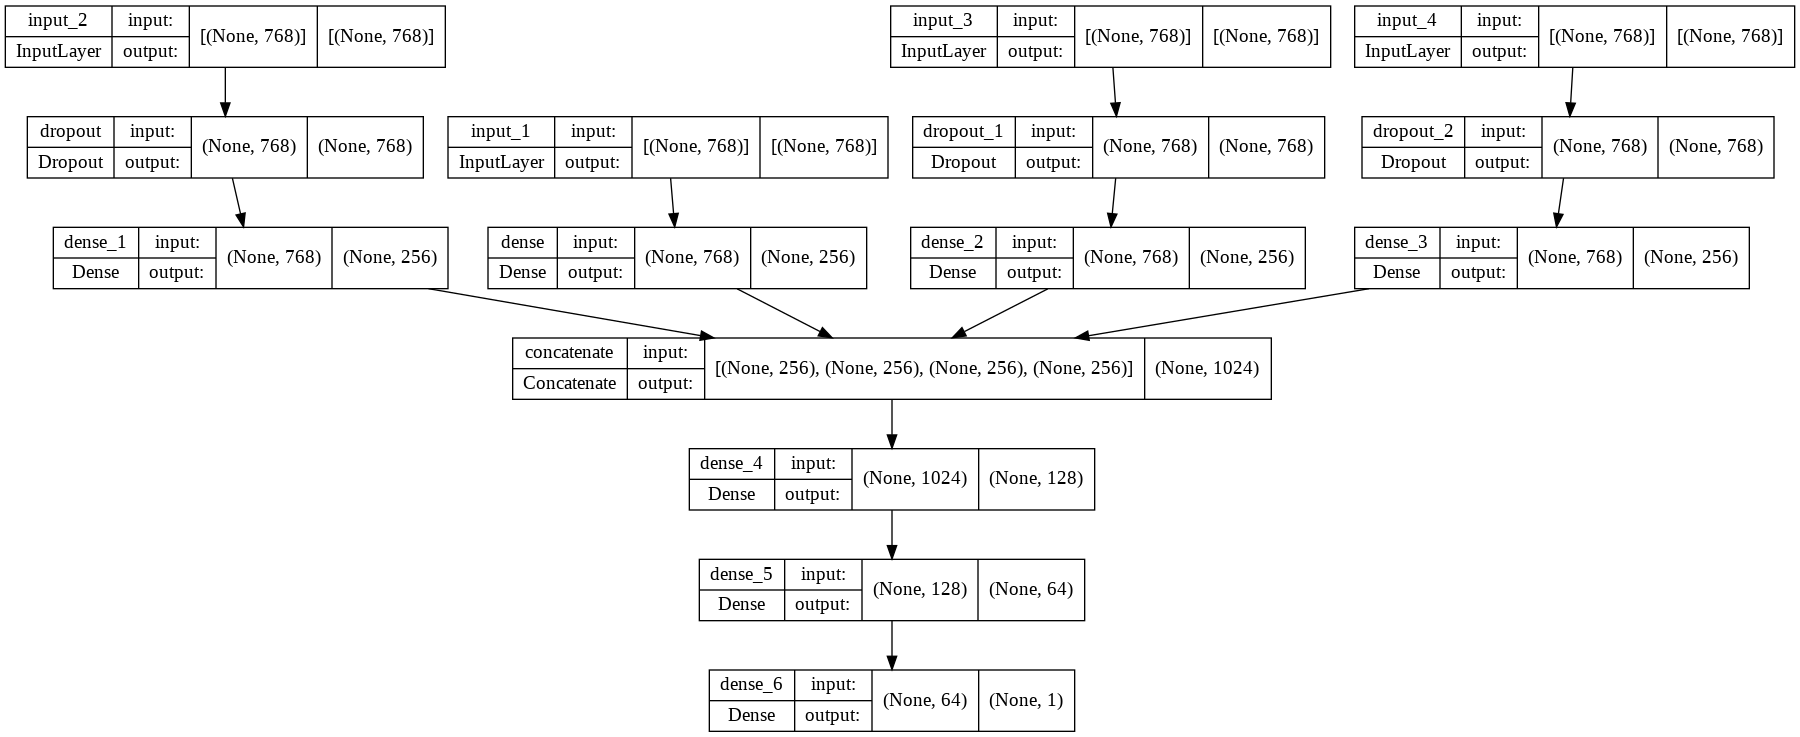

In [55]:

plot_model(model, to_file='BERT plot.png', show_shapes=True, show_layer_names=True)

In [56]:
#compile BERT model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',
    metrics=[RootMeanSquaredError()])

In [57]:
bert_ = model.fit(x=[train_titles_pooled_output,train_descr_pooled_output,train_attributes_pooled_output,
        train_search_term_pooled_output],y=train_pred,epochs=35,batch_size=1024,
        callbacks=[EarlyStopping(patience=2,restore_best_weights=True)],
        validation_data=([valid_titles_pooled_output,valid_descr_pooled_output,valid_attributes_pooled_output,
                          valid_search_term_pooled_output],valid_pred))


Epoch 1/35
47/47 [==============================] - 2s 24ms/step - loss: 0.6248 - root_mean_squared_error: 0.7905 - val_loss: 0.2856 - val_root_mean_squared_error: 0.5344
Epoch 2/35
47/47 [==============================] - 1s 18ms/step - loss: 0.3618 - root_mean_squared_error: 0.6015 - val_loss: 0.2845 - val_root_mean_squared_error: 0.5334
Epoch 3/35
47/47 [==============================] - 1s 18ms/step - loss: 0.3437 - root_mean_squared_error: 0.5863 - val_loss: 0.2806 - val_root_mean_squared_error: 0.5297
Epoch 4/35
47/47 [==============================] - 1s 17ms/step - loss: 0.3292 - root_mean_squared_error: 0.5738 - val_loss: 0.2835 - val_root_mean_squared_error: 0.5324
Epoch 5/35
47/47 [==============================] - 1s 18ms/step - loss: 0.3212 - root_mean_squared_error: 0.5667 - val_loss: 0.2778 - val_root_mean_squared_error: 0.5271
Epoch 6/35
47/47 [==============================] - 1s 17ms/step - loss: 0.3090 - root_mean_squared_error: 0.5558 - val_loss: 0.2813 - val_root_m

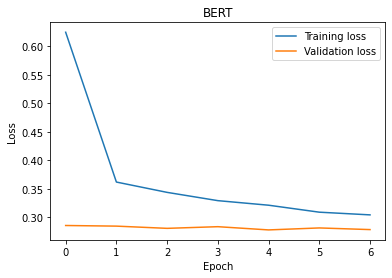

In [58]:
plt.plot(range(len(bert_.history["loss"])), bert_.history["loss"], bert_.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('BERT')
plt.show()

In [59]:
y_pred = model.predict([test_titles_pooled_output,test_descr_pooled_output,
                        test_attributes_pooled_output,test_search_term_pooled_output])


In [60]:
rmse = mean_squared_error(y_pred,test_pred,squared=False)
mse = mean_squared_error(y_pred,test_pred)
mae = median_absolute_error(y_pred,test_pred)

print("RMSE on test data :",rmse)
print("MSE on test data  :",mse)
print("MAE on test data  :",mae)

RMSE on test data : 0.5285483046053597
MSE on test data  : 0.2793633103012001
MAE on test data  : 0.38443299293518063


Text(0.5, 1.0, 'Analysis on BERT')

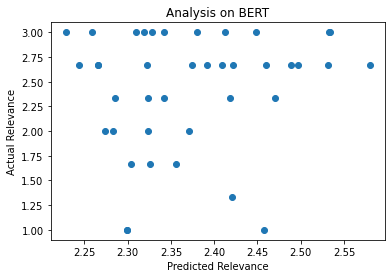

In [61]:
plt.scatter(y_pred[:40],test_pred[:40])
plt.xlabel("Predicted Relevance")
plt.ylabel("Actual Relevance")
plt.title("Analysis on BERT")

In [63]:
t = time.time()

titles_tokens,titles_mask,titles_segment = mask_and_segment(test['preprocessed_title'].values[0:1],30)
descr_tokens,descr_mask,descr_segment = mask_and_segment(test['preprocessed_description'].values[0:1],150)
attr_tokens,attr_mask,attr_segment = mask_and_segment(test['preprocessed_attributes'].values[0:1],150)
search_tokens,search_mask,search_segment = mask_and_segment(test['search_term'].values[0:1],15)

title_pooled_output=model_titles.predict((titles_tokens,titles_mask,titles_segment))
descr_pooled_output=model_attr_descr.predict((descr_tokens,descr_mask,descr_segment))
attr_pooled_output=model_attr_descr.predict((attr_tokens,attr_mask,attr_segment ))
search_term_pooled_output=model_searchterm.predict((search_tokens,search_mask,search_segment))

pred = model.predict([title_pooled_output,descr_pooled_output,attr_pooled_output,search_term_pooled_output])
time_taken = time.time()-t
print("Time taken by Bert model to predict the relevance: ",time_taken)

Time taken by Bert model to predict the relevance:  11.504122257232666
